<p align="left">
<img src="https://raw.githubusercontent.com/dewdotninja/exams/main/feng_heading_en.png" width=400 alt="Feng heading"/>
</p>

## Homework 5 : 
<p />01205479 Internet of Things for Electrial Engineering
<p />Academic year 2022. First semester.


<a href="https://colab.research.google.com/github/dewdotninja/embedded_iot/blob/master/y2022/EEIoT22/HWs/EEIoT22_hw5_soln.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# For colab user, install additional libraries
!pip install control

In [2]:
# import libraries you want to use
import numpy as np
import matplotlib.pyplot as plt
import control as ctl

***
### List of Homework problems (total 10 points)

* [P1. (10 points)](#p1)


<a id="p1"></a>
#### P1. (10 points)

In this homework assignment, you learn how to implement a discrete-time PID controller, and 
verify by simulation that the step response should match with that of the continuous-time. 
If that is the case, then you will have enough confidence to implement it on an embedded system.

The plant used is the same 3rd-order lag that is constructed using op-amps and RC networks.

$$
P(s) = \frac{1}{(s+1)^3}
$$

The PID controller has the following transfer function.

$$
C(s) = K_p + \frac{K_i}{s} + \frac{NK_d}{N/s+1}
$$

The feedback diagram is shown in Figure 1.

<p align="center">
<img src="https://drive.google.com/uc?id=1wb4TYWleOeD6bRXm5VTWdRqbuRWfmiRv" width=550 />
</p>
<div align="center"><b>Figure 1 Basic closed-loop system with unity feedback</b></div>

### Solution

To help you get started, some of the code is provided for you below. Just fill in the 
missing code.

The plant can be constructed as follows.


In [3]:
# --- 3rd-order-lag plant -----
s = ctl.tf("s")
P = 1/(s+1)**3
P


TransferFunction(array([1]), array([1, 3, 3, 1]))

and the PID controller in continuous-time

In [4]:
Kp = 4.8  # you can change PID parameters to your desired values
Ki = 2.6  # as long as closed-loop system is stable
Kd = 2.2 
N = 100
C = Kp + Ki/s + N*Kd*s/(N+s)
C

TransferFunction(array([224.8, 482.6, 260. ]), array([  1, 100,   0]))

Run the following code to simulate step response in continuous-time. 

0 states have been removed from the model


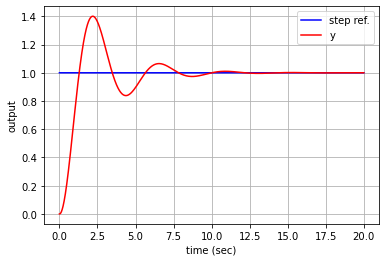

In [5]:
tvec = np.arange(0,20,0.01)  # you can change time vector 
r = np.ones(tvec.shape)
L = C*P
T = ctl.minreal(ctl.feedback(L))
tv, y = ctl.step_response(T, tvec)
plt.figure()
plt.plot(tv,r,'b',tv,y,'r-')
plt.grid('True')
plt.xlabel('time (sec)')
plt.ylabel('output')

plt.legend(['step ref.','y'])
plt.show()


Now, to implement the discrete-time simulation, first we need to discretize the plant. 
This is done for you in the cell below.

In [6]:
Ts = 0.01  # this can be changed, though too large sampling time may yield poor result.
Pd = ctl.sample_system(P, Ts, method='tustin')
Pdnum, Pdden = ctl.tfdata(Pd)
#print(Pdnum)
#print(Pdden)
pdnum = np.squeeze(np.array(Pdnum))
pdden = np.squeeze(np.array(Pdden))
numorder = len(pdnum)  # 4 for this example
denorder = len(pdden)  # 4
y_prev = np.zeros((denorder,1)) 
u_prev = np.zeros((numorder,1))

Your task is to implement PID function in the cell below.

In [7]:
e_1 = 0
u_i1 = 0
u_d1 = 0
u_p0 = 0
u_i0 = 0
u_d0 = 0
u_0 = 0
e_0 = 0
# PID controller function
def PID_control(r,y): 
    global e_0,u_p0, u_i0, u_d0
    e_1 = e_0  # e_1 = e(k-1), e_0 = e(k)
    u_i1 = u_i0 # u_i1 = ui(k-1)
    u_d1 = u_d0 
    e_0 = r - y
    u_p0 = Kp*e_0
    u_i0 = u_i1 + 0.5*Ki*Ts*(e_0+e_1)
    u_d0 = -((N*Ts-2)/(2+N*Ts))*u_d1 + (2*Kd*N/(2+N*Ts))*(e_0-e_1)
    u_0 = u_p0 + u_i0 + u_d0
    return u_0


and use the PID function in this simulation

In [11]:
i = 0
tvec = np.arange(0,20,Ts)
rvec = np.ones(tvec.shape)  # use tvec defined above
yvec = np.zeros(tvec.shape)
uvec = np.zeros(tvec.shape)

# reset plant & controller states
y_prev = np.zeros((denorder,1)) 
u_prev = np.zeros((numorder,1))
e_1 = 0
u_i1 = 0
u_d1 = 0
u_p0 = 0
u_i0 = 0
u_d0 = 0
u_0 = 0
e_0 = 0

# perform discrete-time simulation 
for i in range(len(tvec)):

    for k in range(numorder-1):
        u_prev[k] = u_prev[k+1]
    for k in range(denorder-1):
        y_prev[k] = y_prev[k+1]
        

    uvec[i] = PID_control(rvec[i],yvec[i-1])

    u_prev[numorder-1] = uvec[i]        
    yvec[i] = pdnum[0]*uvec[i]
    for k in range(denorder-1):
        yvec[i] = yvec[i]+pdnum[k+1]*u_prev[numorder-2-k] - pdden[k+1]*y_prev[denorder-2-k]
        #print(pdnum[k+1])
        #print(pdden[k+1])
        #print()
    y_prev[denorder-1] = yvec[i]

If things work correctly, you should be able to plot a step-response comparison using the 
following code. The responses should match closely.

In [9]:
tv, yc = ctl.step_response(T, tvec)

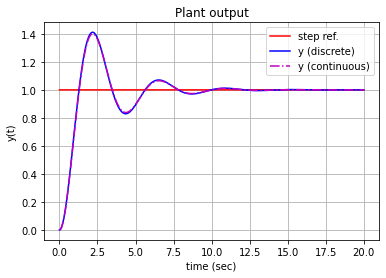

In [12]:
plt.figure()
plt.plot(tvec,rvec,'r-',tvec, yvec,'b-',tv,yc,'m-.')
plt.grid('True')
plt.xlabel('time (sec)')
plt.ylabel('y(t)')

plt.legend(['step ref.','y (discrete)','y (continuous)'])
plt.title("Plant output")

plt.show()

##### Rev. 1A : September 2022